##**Associated Net for Open, High and Low**

Data Flow

    input(NSEI, AMBUJACEM, ASIANPAINT, BHEL, HINDUNILVR)
                              |
                              |
                              V
                    (feature selection)
                              |
                              |
                              V
                        n_features
                              |
                              |
                              V
              (associated_netauteoencoder)
                              |
                              |
                              V
                        output(NSEI)

##**Preparing Environment**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install plotly==4.13.0
!pip install pyswarms

     |████████████████████████████████| 5.5MB 6.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=4103a568a6bb8068add755358b7c7753418ae27a1a0cdae3cfa9e943ca40fa43
  Stored in directory: /tmp/pip-ephem-wheel-cache-8hr5cub4/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 13.1MB 215kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 112kB 4.0MB/s 


In [ ]:
#Importing Libraries
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model
import tensorflow as tf
from keras import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, Dropout, Input, Lambda, concatenate
from sklearn.metrics import mean_absolute_error
import pyswarms as pso
import pandas as pd
import plotly.graph_objects as go
tf.__version__

'2.4.1'

##**Importing data from yfinance**

In [ ]:
yf.pdr_override()
TICKER_LIST = ['^NSEI','AMBUJACEM.NS','ASIANPAINT.NS','BHEL.NS','HINDUNILVR.NS']
START = "2010-01-01"
END = "2021-01-01"
dflist = []
for t in TICKER_LIST:
  df = pdr.get_data_yahoo(t, start=START, end=END)
  df = df[['Open','Low','High']]
  #df = df[['Open','Low','High','Close','Adj Close','Volume']]
  dflist.append(df)


2021-03-09 08:52:45,797 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
dflist[0].head()

,Open,Low,High
Date,,,
2010-01-04,5200.899902,5167.100098,5238.450195
2010-01-05,5277.149902,5242.399902,5288.350098
2010-01-06,5278.149902,5260.049805,5310.850098
2010-01-07,5281.799805,5244.750000,5302.549805
2010-01-08,5264.250000,5234.700195,5276.750000


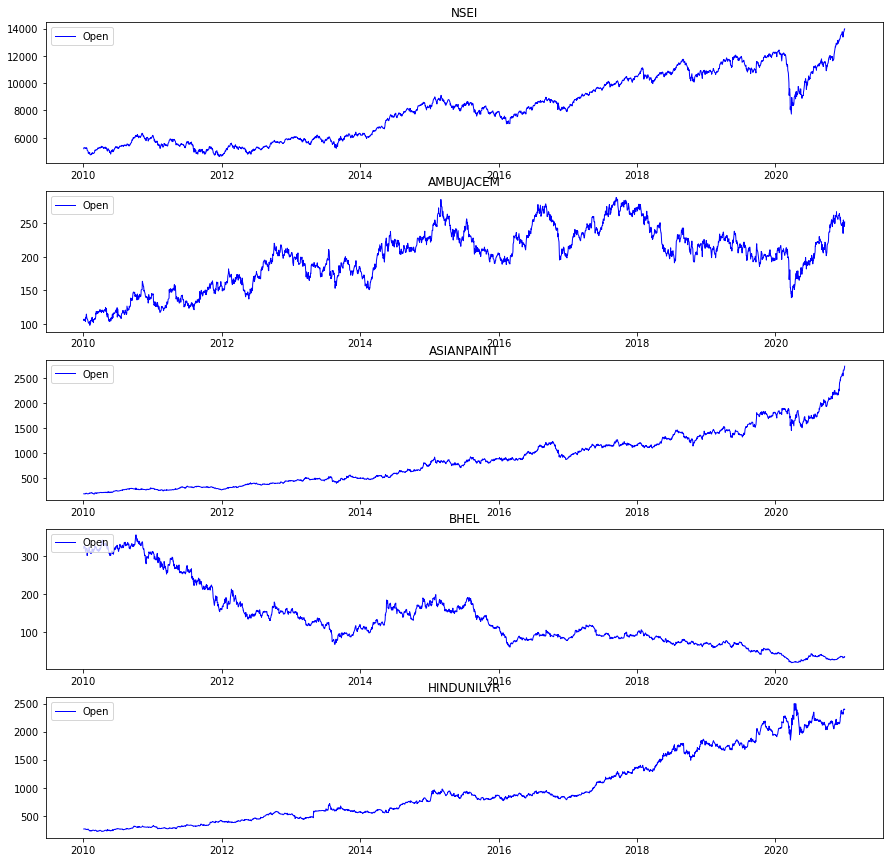

In [ ]:
#plotting open prices from all charts

plt.figure(figsize=(15,15))

plt.subplot(511)
plt.plot(dflist[0]['Open'],'b',linewidth=1)
plt.title('NSEI')
plt.legend(['Open'], loc='upper left')

plt.subplot(512)
plt.plot(dflist[1]['Open'],'b',linewidth=1)
plt.title('AMBUJACEM')
plt.legend(['Open'], loc='upper left')

plt.subplot(513)
plt.plot(dflist[2]['Open'],'b',linewidth=1)
plt.title('ASIANPAINT')
plt.legend(['Open'], loc='upper left')

plt.subplot(514)
plt.plot(dflist[3]['Open'],'b',linewidth=1)
plt.title('BHEL')
plt.legend(['Open'], loc='upper left')

plt.subplot(515)
plt.plot(dflist[4]['Open'],'b',linewidth=1)
plt.title('HINDUNILVR')
plt.legend(['Open'], loc='upper left')

plt.show()

##Feature Selection using Pyswarm


In [ ]:
standard_scaler = StandardScaler()

scaled_dflist = standard_scaler.fit_transform(pd.concat(dflist,axis=1))

y_arr = np.nan_to_num(scaled_dflist[:,0].copy(),0)
X_arr = np.nan_to_num(scaled_dflist[:,3:].copy(),0)

total_features = X_arr.shape[1]
print('Total Features:',total_features)

Total Features: 12


In [ ]:
X_arr

array([[-2.15162138, -2.15138123, -2.18229649, ..., -1.14595275,
        -1.14308068, -1.14829945],
       [-2.11484554, -2.12814464, -2.15139661, ..., -1.14439967,
        -1.14572813, -1.14797601],
       [-2.15277069, -2.15021933, -2.17657429, ..., -1.14603447,
        -1.14556266, -1.14862293],
       ...,
       [ 1.11568464,  1.07850411,  1.05990597, ...,  2.33648729,
         2.31529917,  2.30756513],
       [ 1.06856549,  1.05991477,  1.1686279 , ...,  2.32831331,
         2.35137057,  2.32640662],
       [ 1.21796746,  1.18074494,  1.16176118, ...,  2.33812208,
         2.3695717 ,  2.33020745]])

In [ ]:
y_arr

array([-1.21490376, -1.1826783 , -1.18225567, ...,  2.46596159,
        2.49577839,  2.49117157])

In [ ]:
classifier = linear_model.LinearRegression()


# Define objective function
def f_per_particle(m, alpha):
    
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0:
        X_subset = X_arr
        
    else:
        
        X_subset = X_arr[:,m==True]
    # Perform classification and store performance in P
    classifier.fit(X_subset, y_arr)
    P = mean_absolute_error(classifier.predict(X_subset),y_arr)

    # Compute for the objective function
    j = (alpha * (1.0 - P)+ (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

def f(x, alpha=0.88):
    
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

# Initialize swarm, arbitrary
options = {'c1': 0.25, 'c2': 0.8, 'w':0.9, 'k': 30, 'p':2}

# Call instance of PSO
dimensions = total_features # dimensions should be the number of features
optimizer = pso.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options)
#optimizer.reset()

# Perform optimization
cost, pos = optimizer.optimize(f,iters=1000)

2021-03-09 08:52:48,646 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 0.25, 'c2': 0.8, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|1000/1000, best_cost=0.454
2021-03-09 08:54:02,930 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.45431456835356554, best pos: [0 0 0 0 0 0 1 1 1 0 0 0]


In [ ]:
print('best cost:',cost)
fpos = np.concatenate((np.array([1,1,1]),pos))
print('best pos:',fpos,len(fpos))

best cost: 0.45431456835356554
best pos: [1 1 1 0 0 0 0 0 0 1 1 1 0 0 0] 15


##**Preparing Dataset for Training**

##**Scaling Data**

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
df_arr = np.nan_to_num(np.array(pd.concat(dflist,axis=1)),0)[:,fpos==1]
scaled_data = scaler.fit_transform(df_arr)
print(scaled_data.shape)

(2711, 6)


In [ ]:
#window size
WINDOW_SIZE = 5
TRAINING_DATA_LEN = int(scaled_data.shape[0]*0.75)

In [ ]:
#Create the scaled training data set
train_data = scaled_data[0:int(TRAINING_DATA_LEN), :]

#Split the data into x and y data sets
x = []
y = []

for i in range(WINDOW_SIZE, len(scaled_data)):
    x.append( scaled_data[i-WINDOW_SIZE:i,:] )
    y.append( scaled_data[i,:3] )

x_train = x[:TRAINING_DATA_LEN]
y_train = y[:TRAINING_DATA_LEN]
x_test = x[TRAINING_DATA_LEN:]
y_test = y[TRAINING_DATA_LEN:]

x_train,y_train = shuffle(x_train,y_train)

x_train, y_train, x_test, y_test = np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)

print('scaled_data shape:', scaled_data.shape,'\nx_train shape:',x_train.shape,'\ny_train shape:',y_train.shape,'\nx_test shape:',x_test.shape,'\ny_test shape:',y_test.shape)

scaled_data shape: (2711, 6) 
x_train shape: (2033, 5, 6) 
y_train shape: (2033, 3) 
x_test shape: (673, 5, 6) 
y_test shape: (673, 3)


##**Model Architecture**

In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(WINDOW_SIZE,scaled_data.shape[-1]),ragged=True)

lstm11 = LSTM(10,return_sequences=True)(input_layer)
dropout11 = Dropout(0.3)(lstm11)
lstm12 = LSTM(10,return_sequences=False)(dropout11)
dropout12 = Dropout(0.3)(lstm12)
#dense1 = Dense(3,activation='relu')(dropout12)
output1 = Dense(1,activation='sigmoid')(dropout12)
model1 = Model(inputs=input_layer, outputs=output1)

lstm21 = LSTM(10,return_sequences=True)(input_layer)
expanded_output1 = tf.expand_dims(tf.matmul(model1.output,tf.ones([1,WINDOW_SIZE])),axis=-1)
inputs_2 = tf.concat([lstm21,expanded_output1],axis=2)
lstm22 = LSTM(10,return_sequences=True)(inputs_2)
dropout21 = Dropout(0.3)(lstm22)
lstm23 = LSTM(10,return_sequences=False)(dropout21)
dropout22 = Dropout(0.3)(lstm23)
output2 = Dense(1,activation='sigmoid')(dropout22)
model2 = Model(inputs=input_layer,outputs=output2)

lstm31 = LSTM(10,return_sequences=True)(input_layer)
expanded_output2 = tf.expand_dims(tf.matmul(model2.output,tf.ones([1,WINDOW_SIZE])),axis=-1)
inputs_3 = tf.concat([lstm31,expanded_output1,expanded_output2],axis=2)
lstm32 = LSTM(10,return_sequences=True)(inputs_3)
dropout31 = Dropout(0.3)(lstm32)
lstm33 = LSTM(10,return_sequences=False)(dropout31)
dropout32 = Dropout(0.3)(lstm33)
output3 = Dense(1,activation='sigmoid')(dropout32)
model3 = Model(inputs=input_layer,outputs=output3)

final_output = tf.concat([model1.output,model2.output,model3.output],axis=-1)

associated_net = Model(inputs=input_layer,outputs=final_output)
associated_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 6)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 5, 10)        680         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 5, 10)        0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10)           840         dropout[0][0]                    
____________________________________________________________________________________________

In [ ]:
associated_net.compile(optimizer="adam", loss="mse", metrics=["mse"])
history = associated_net.fit(x_train, y_train, epochs=100,batch_size=64, validation_data=(x_test,y_test))

Epoch 1/100
32/32 [==============================] - 45s 135ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 4/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 5/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 7/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/100
32/32 [==============================] - 1s 29ms/step - loss: 

In [ ]:
p_train = associated_net.predict(x_train)

an_train_open_mae = mean_absolute_error(y_train[:,0],p_train[:,0])
an_train_open_acc = 1-an_train_open_mae
print('Open loss(MAE): ',an_train_open_mae)
print('Open Accuracy(1-MAE): ',an_train_open_acc)


an_train_high_mae = mean_absolute_error(y_train[:,2],p_train[:,2])
an_train_high_acc = 1-an_train_high_mae
print('High loss(MAE): ',an_train_high_mae)
print('High Accuracy(1-MAE): ',an_train_high_acc)


an_train_low_mae = mean_absolute_error(y_train[:,1],p_train[:,1])
an_train_low_acc = 1-an_train_low_mae
print('Close loss(MAE): ',an_train_low_mae)
print('Close Accuracy(1-MAE): ',an_train_low_acc)

print('Average Accuracy: ', (an_train_open_acc+an_train_high_acc+an_train_low_acc)/3)

Open loss(MAE):  0.014424542230940657
Open Accuracy(1-MAE):  0.9855754577690593
High loss(MAE):  0.015761097811479538
High Accuracy(1-MAE):  0.9842389021885205
Close loss(MAE):  0.016370859879986644
Close Accuracy(1-MAE):  0.9836291401200133
Average Accuracy:  0.984481166692531


In [ ]:
print('Average Accuracy: ', (an_train_open_acc+an_train_high_acc+an_train_low_acc)/3)

Average Accuracy:  0.984481166692531


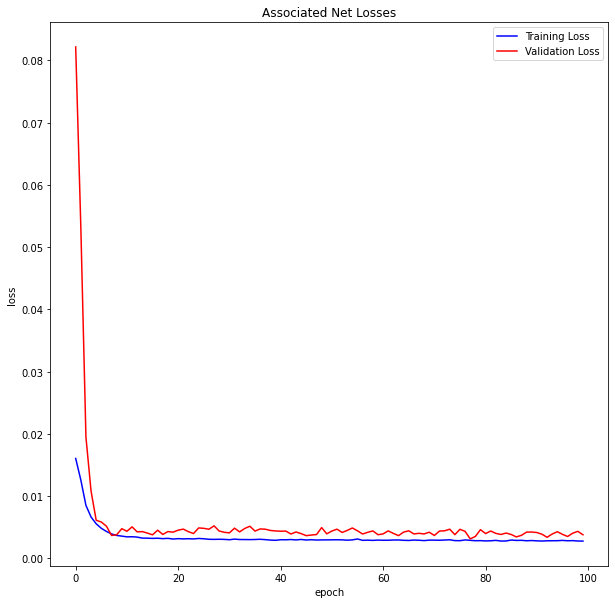

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'r')
plt.title('Associated Net Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

##**Predicting on Test Data**

In [ ]:
p_test = associated_net.predict(x_test)

an_test_open_mae = mean_absolute_error(y_test[:,0],p_test[:,0])
an_test_open_acc = 1-an_test_open_mae
print('Open loss(MAE): ',an_test_open_mae)
print('Open Accuracy(1-MAE): ',an_test_open_acc)


an_test_high_mae = mean_absolute_error(y_test[:,2],p_test[:,2])
an_test_high_acc = 1-an_test_high_mae
print('High loss(MAE): ',an_test_high_mae)
print('High Accuracy(1-MAE): ',an_test_high_acc)


an_test_low_mae = mean_absolute_error(y_test[:,1],p_test[:,1])
an_test_low_acc = 1-an_test_low_mae
print('Close loss(MAE): ',an_test_low_mae)
print('Close Accuracy(1-MAE): ',an_test_low_acc)

an_avg = (an_test_open_acc+an_test_high_acc+an_test_low_acc)/3

print('Average Accuracy: ', an_avg)

Open loss(MAE):  0.04842384329788297
Open Accuracy(1-MAE):  0.951576156702117
High loss(MAE):  0.043254353894794755
High Accuracy(1-MAE):  0.9567456461052053
Close loss(MAE):  0.04780660034553187
Close Accuracy(1-MAE):  0.9521933996544681
Average Accuracy:  0.9535050674872635


In [ ]:
#Rescaling
ptemp = np.concatenate([p_test,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,3:]],axis=1)
print(ptemp.shape)
ytemp = np.concatenate([y_test,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,3:]],axis=1)
print(ytemp.shape)
p_rescaled = scaler.inverse_transform(ptemp)
y_rescaled = scaler.inverse_transform(ytemp)

(673, 6)
(673, 6)


In [ ]:
p_rescaled.shape

(673, 6)

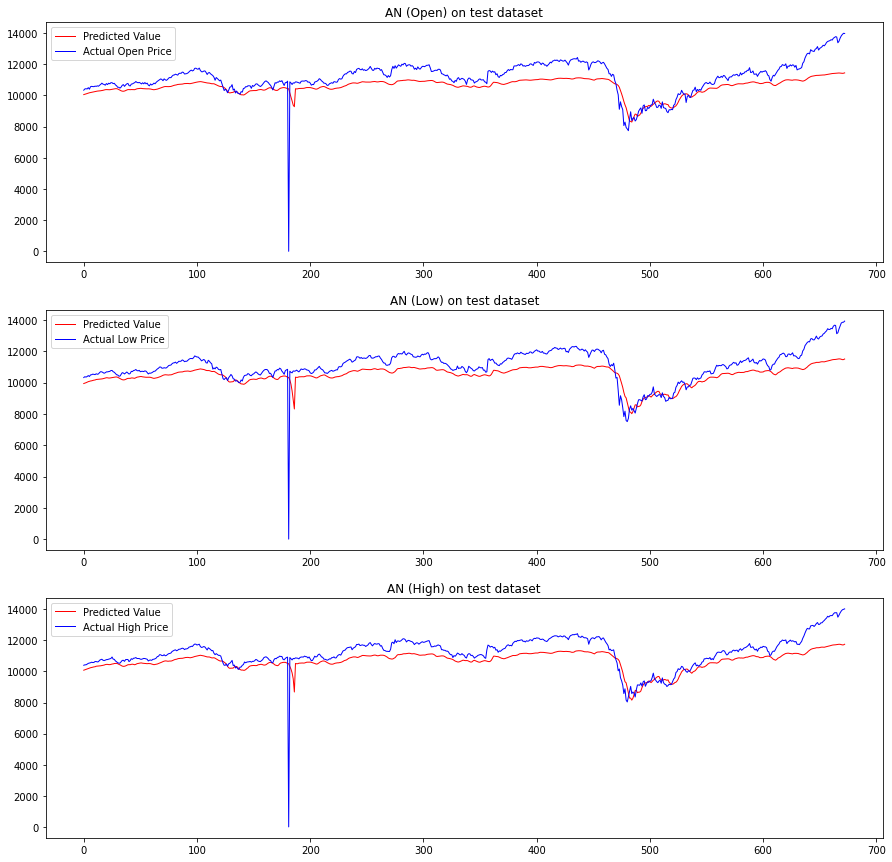

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.plot(p_rescaled[:,0],'r',linewidth=1)
plt.plot(y_rescaled[:,0],'b',linewidth=1)
plt.title('AN (Open) on test dataset')
plt.legend(['Predicted Value', 'Actual Open Price'], loc='upper left')
plt.subplot(312)
plt.plot(p_rescaled[:,1],'r',linewidth=1)
plt.plot(y_rescaled[:,1],'b',linewidth=1)
plt.title('AN (Low) on test dataset')
plt.legend(['Predicted Value', 'Actual Low Price'], loc='upper left')
plt.subplot(313)
plt.plot(p_rescaled[:,2],'r',linewidth=1)
plt.plot(y_rescaled[:,2],'b',linewidth=1)
plt.title('AN (High) on test dataset')
plt.legend(['Predicted Value', 'Actual High Price'], loc='upper left')
plt.show()